##### Set up packages and directories

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import pickle
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, fftfreq
from Bio import Entrez, SeqIO, AlignIO, pairwise2, Align, Seq, motifs
from Bio.Seq import Seq
from Bio.SeqFeature import SeqFeature, FeatureLocation
from scipy.stats import binom
import math
from tqdm.auto import tqdm
from Comparative_Analysis import Sequence_Analysis_Routines as sar
from Comparative_Analysis import Utilities as util
from Comparative_Analysis import Alignment as align
from Comparative_Analysis import ORF_Functions as orffn
import random
import copy
from joblib import Parallel, delayed
import os
import subprocess
from Bio.Blast import NCBIWWW, NCBIXML
from Bio.Align.Applications import MuscleCommandline
muscle_exe = 'C:/Users/nicho/Muscle/muscle3.8.31_i86win32.exe'

In [24]:
project_dir = 'F:/Project_Data/Project_10'
literature_datasets_dir = 'F:/Datasets/Data_From_Publications'
output_dir = project_dir + '/Output'
refseq_dir = 'F:/Datasets/NCBI_Refseq_Mycobacteriaceae_All_Levels/ncbi_dataset/data'
mycobrowser_dir = 'F:/Datasets/Data_From_Publications'
num_cores = 8
core_numbers = list(range(1, num_cores+1))

In [3]:
reference_species = 'GCF_000195955.2'

In [22]:
with open('F:/Project_Data/Project_11/Thoth_Full_Run/zero_and_non_zero_mutation_counts.pkl', 'rb') as f:
    full_sample_zero_and_non_zero_mutation_counts = pickle.load(f)  
compass_df = pd.read_csv('F:/Datasets/CRYPTIC_DATA/COMPASS.csv', names = ['species', 'start', 'stop','count'])
compass_dict = {}
for i, r in compass_df.iterrows():
    for k in range(r['start'], r['stop']):     #  Should te start-1 but seems to ve inconsistency with mutations!!
        compass_dict[k] = 'Y'

In [49]:
myco_annotation_features_dict = {}
mycobrowser_df = pd.read_excel(mycobrowser_dir+'/Mycobrowser_Release_4.xlsx')
temp_cds = mycobrowser_df[mycobrowser_df['Feature'] == 'CDS'][['Locus','Start','Stop','Strand','Product']]      #Just CDS
mycobrowser_cds_boundaries = []
for i, r in temp_cds.iterrows():
    if r['Strand'] == '+':
        strand = 1
        myco_annotation_features_dict[int(r['Stop'])] = [r['Locus'],r['Product'], r['Start']-1, r['Stop'], strand]
    else:
        strand = -1
        myco_annotation_features_dict[int(r['Start'])-1] = [r['Locus'],r['Product'], r['Start']-1, r['Stop'], strand]


In [109]:
new_annotation_features_dict = {}
genome_record = next(SeqIO.parse(project_dir + '/annot.gbk', "genbank"))
for feature in genome_record.features:
        a = feature.qualifiers
        if feature.type == 'CDS' and a.get("locus_tag")!= None and int(feature.location.end) - int(feature.location.start) < 100000:  #  Exclude strange Biopython parsing where starts with complement join and looks like a CDS is full length of genome!   
            locus_tag = a.get("locus_tag")[0]
            if a.get("product") != None:
                product = a.get("product")[0]
            else:
                product = ''
            if not(a.get("pseudo") == None):
                locus_tag = 'pseudo_'+ locus_tag
            if int(feature.location.strand) == 1:
                new_annotation_features_dict[int(feature.location.end)] = ([locus_tag, product, int(feature.location.start), int(feature.location.end), 
                                                                         int(feature.location.strand)])
            else:
                new_annotation_features_dict[int(feature.location.start)] = ([locus_tag, product, int(feature.location.start), int(feature.location.end), 
                                                                         int(feature.location.strand)])

In [51]:
old_annotation_features_dict = {}
genome_record = next(SeqIO.parse(refseq_dir + '/'+reference_species+'/genomic.gbff', "genbank"))
for feature in genome_record.features:
        a = feature.qualifiers
        if feature.type == 'CDS' and a.get("locus_tag")!= None and int(feature.location.end) - int(feature.location.start) < 100000:  #  Exclude strange Biopython parsing where starts with complement join and looks like a CDS is full length of genome!   
            locus_tag = a.get("locus_tag")[0]
            if a.get("product") != None:
                product = a.get("product")[0]
            else:
                product = ''
            if int(feature.location.strand) == 1:
                old_annotation_features_dict[int(feature.location.end)] = ([locus_tag, product, int(feature.location.start), int(feature.location.end), 
                                                                         int(feature.location.strand)])
            else:
                old_annotation_features_dict[int(feature.location.start)] = ([locus_tag, product, int(feature.location.start), int(feature.location.end), 
                                                                         int(feature.location.strand)])

In [55]:
temp = []
for k, v in old_annotation_features_dict.items():
    temp.append(k)
for k, v in new_annotation_features_dict.items():
    temp.append(k)
for k, v in myco_annotation_features_dict.items():
    temp.append(k)
stops = list(set(temp))
stops.sort()

In [56]:
def bin_formula(position_3_counts, tot_bin_counts):
    return 1- binom.cdf(position_3_counts-1, tot_bin_counts,1/3)
def score_region(mutationcounts, start):
    bin_counts = [0,0,0]
    for n in range(int(len(mutationcounts)/3)):
        temp_counts = [0,0,0]
        compass_overlap = 0
        for m in range(3): 
            if start+3*n+m in compass_dict:
                compass_overlap = 1
            temp_counts[m % 3] = mutationcounts[3*n+m]
        if sum(temp_counts) < 10 and compass_overlap == 0:
            for m in range(3):
                bin_counts[m] += temp_counts[m]
    return bin_formula(bin_counts[2], sum(bin_counts))

In [75]:
def compass_coverage(start, stop):
    compass_overlap = 0
    for i in range(start, stop):
        if i in compass_dict:
            compass_overlap += 1
    return (compass_overlap/(stop - start))

In [110]:
final_list = []
for i in stops:
    temp = []
    if i in old_annotation_features_dict:
        a = old_annotation_features_dict[i]
        start = a[2]
        end = a[3]
        strand = int(a[4])
        mutation_counts = full_sample_zero_and_non_zero_mutation_counts[start:end]
        if strand == 1:
            stop = end
            mutation_counts_2 = mutation_counts
        else:
            stop = start
            mutation_counts_2 = list(reversed(mutation_counts))
        temp.append([a[0],a[1],a[2],a[3],a[4], score_region(mutation_counts_2, start)])
    else:
        temp.append(['','','','','',''])
    if i in myco_annotation_features_dict:
        a = myco_annotation_features_dict[i]
        start = a[2]
        end = a[3]
        mutation_counts = full_sample_zero_and_non_zero_mutation_counts[start:end]
        if strand == 1:
            stop = end
            mutation_counts_2 = mutation_counts
        else:
            stop = start
            mutation_counts_2 = list(reversed(mutation_counts))
        temp.append([a[0],a[1],a[2],a[3],a[4], score_region(mutation_counts_2, start)])
    else:
        temp.append(['','','','','',''])
        
    if i in new_annotation_features_dict:
        a = new_annotation_features_dict[i]
        start = a[2]
        end = a[3]
        mutation_counts = full_sample_zero_and_non_zero_mutation_counts[start:end]
        if strand == 1:
            stop = end
            mutation_counts_2 = mutation_counts
        else:
            stop = start
            mutation_counts_2 = list(reversed(mutation_counts))
        temp.append([a[0],a[1],a[2],a[3],a[4], score_region(mutation_counts_2, start)])
    else:
        temp.append(['','','','','',''])
    flat_list = []
    for sublist in temp:
        for item in sublist:
            flat_list.append(item) 
    final_list.append(flat_list)
comparison_df = pd.DataFrame(final_list, columns = ['locus_1', 'product_1', 'start_1', 'stop_1', 'strand_1', 'score_1',
                              'locus_2', 'product_2', 'start_2', 'stop_2', 'strand_2', 'score_2',
                              'locus_3', 'product_3', 'start_3', 'stop_3', 'strand_3', 'score_3'])
comparison_df.to_csv(project_dir + '/annotation_comparison.csv')

[Text(0.5, 0, 'P-value'),
 Text(0, 0.5, 'Cumulative Proportion'),
 Text(0.5, 1.0, '')]

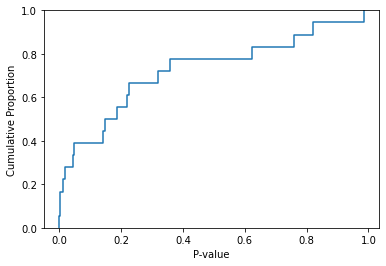

In [103]:
temp = comparison_df.query("not(locus_1 == '') and (locus_2 == '') and not(locus_3 == '')")['score_3'].values.tolist()
a = sns.ecdfplot(temp)
a.set(xlabel ="P-value", ylabel = "Cumulative Proportion", title ='')

  0%|          | 0/3936 [00:00<?, ?it/s]

[Text(0.5, 0, 'P-value'),
 Text(0, 0.5, 'Cumulative Proportion'),
 Text(0.5, 1.0, '')]

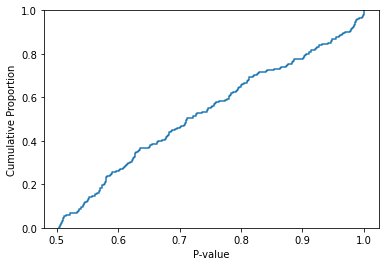

In [107]:
scores = []
for k, v in tqdm(new_annotation_features_dict.items()):
    mutation_counts = full_sample_zero_and_non_zero_mutation_counts[v[2]:v[3]]
    if compass_coverage(v[2], v[3]) > 0.5:
        continue
    if v[4] == 1:
        mutation_counts_2 = mutation_counts
    else:
        mutation_counts_2 = list(reversed(mutation_counts))
    scores.append(score_region(mutation_counts_2, v[2]))
a = sns.ecdfplot([x for x in scores if x > 0.5])
a.set(xlabel ="P-value", ylabel = "Cumulative Proportion", title ='')

In [74]:
scores =[]
for (locus, product, start, stop, strand, name, functional_category, gene_ontology) in mycobrowser_cds_boundaries: 
    if compass_coverage(start, stop) > 0.5:
        continue
    mutation_counts = full_sample_zero_and_non_zero_mutation_counts[start:stop]
    if strand == 1:
        mutation_counts_2 = mutation_counts
    else:
        mutation_counts_2 = list(reversed(mutation_counts))
    scores.append(score_region(mutation_counts_2, start))
    #if score_region(mutation_counts_2) < 0.5:
    #    print(locus, show_bin_counts(mutation_counts_2))
a = sns.ecdfplot(scores)
a.set(xlabel ="P-value", ylabel = "Cumulative Proportion", title ='')

4016

In [112]:
with open( 'F:/Project_Data/Project_11/Thoth_Full_Run/variant_df.pkl', 'rb') as f:
    full_variant_df = pickle.load(f)   
full_sample_variant_count_dict = {}
full_sample_variant_counts = full_variant_df.groupby(['GENOME_INDEX'])['UNIQUEID'].count().reset_index()
for i, r in full_sample_variant_counts.iterrows():
    full_sample_variant_count_dict[r['GENOME_INDEX']-1] = r['UNIQUEID']

In [127]:
for record in SeqIO.parse(refseq_dir + '/' + reference_species +'/genomic.gbff', "genbank"):
    full_sequence = str(record.seq)
tr = util.Translator()
tr.translate_sequence(full_sequence[4400215:4400777],1,0, separate_start_symbol = True)

'ZGFGGRHERSDAELLAAHVAGDRYAFDQZFRRHHRQLHRLARLTSRTSEDADDALQDAZLSAHRGAGSFRYDAAVSSWZHRIZVNACLDRLRRAKAHPTAPLEDVYPVADRTAQVETAIAZQRALZRLPVEQRAAZVAZDZQGYSIADTRPDAGRGRGHRQEPLRPGAGPPSAAAGLSQHRGEHPAL'

In [128]:
tr.translate_sequence(full_sequence[4400185:4400854],1,0, separate_start_symbol = True)

'ZPPPIGYCPAZGFGGRHERSDAELLAAHVAGDRYAFDQZFRRHHRQLHRLARLTSRTSEDADDALQDAZLSAHRGAGSFRYDAAVSSWZHRIZVNACLDRLRRAKAHPTAPLEDVYPVADRTAQVETAIAZQRALZRLPVEQRAAZVAZDZQGYSIADTRPDAGRGRGHRQEPLRPGAGPPSAAAGLSQHRGEHPALTPZPVRRSIDPRARRYPTSGYCHRA*'

In [116]:
for i in range(4400215,4400777):
    if not(i in full_sample_variant_count_dict):
        print(0)
    else:
        print(full_sample_variant_count_dict[i])

0
0
1
3
0
0
0
0
82
0
1
1
10
92
2
0
2
3
0
0
2
2
0
177
20
3
2
1
7
4
10610
1
1
0
1
2
0
0
4
0
1
13
0
1
19
6
0
5
7
2
0
5
1
5
0
0
7
1
0
4
3
0
11
2
0
0
29
3
5
0
0
0
1155
0
5
0
16
2
0
4
7
7
3
0
6
3
2
0
0
0
14
11
3
1
1
7
1
1
3
3
2
6
2
0
1
0
1
6
2
0
16
4
1
1
6
0
4
6
4
19
0
0
22
0
1
0
1
0
2
4
15
5
0
73
17
1
90
30
5
15
20
26
1
1
1
0
4
0
7
6
0
0
0
2
6
41
2
1
47
2
0
2
5
0
5
0
0
27
4
1
6
3
0
628
2
0
1
1
0
51
1
0
56
3
1
29
8
3
3
1
1
1
5
4
7
3
0
27
0
0
3
47
12
15
0
0
4
2
3
1
51
96
35
4
1
51
22
1
28
4
2
10
4
2
1
49
1
2
2
0
53
0
2
0
52
1
0
4
0
3
0
7
1
0
1
0
0
0
2
2
0
23
0
1
0
3
0
40
0
3
5
2
7
1
0
0
1
0
0
6
0
1
13
0
12
17
4
6
15
13
35
4
3
0
13
2
0
0
2
0
12
1
0
1
3
2
2
1
8
9
0
17
12
0
0
8
3
0
8
9
7
13
2
0
1
0
0
13
4
0
3
9
2
4
1
0
16
1
1
17
1
1
2
0
2
4
3
1
21
11
4
2
1
1
5
0
0
2
0
1
22
18
2
1
1
0
23
1
2
3
4
1
2
4
67
3
5
14
21
3
3
27
20
1
2
0
0
1
1
8
22
0
1
21
3
4
10
18
1
1
0
0
14
6
0
26
0
3
13
3
1
7
3
0
0
8
0
18
5
2
24
6
11
2
3
1
29
1
1
6
0
0
0
3
1
13
2
0
4
0
0
17
0
3
1
21
1
17
0
2
1
5
31
10275
63627
1
596
3